<a href="https://colab.research.google.com/github/rajni-arora/Deep-Learning-Projects/blob/main/Fine_Tuning_BERT_for_Disaster_Tweets_Classificationt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd 
import numpy as np

import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D

In [6]:
tweet =  pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv'
)

In [4]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
tweet.shape

(7613, 5)

In [6]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Exploratory Data Analysis

In [7]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 120

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

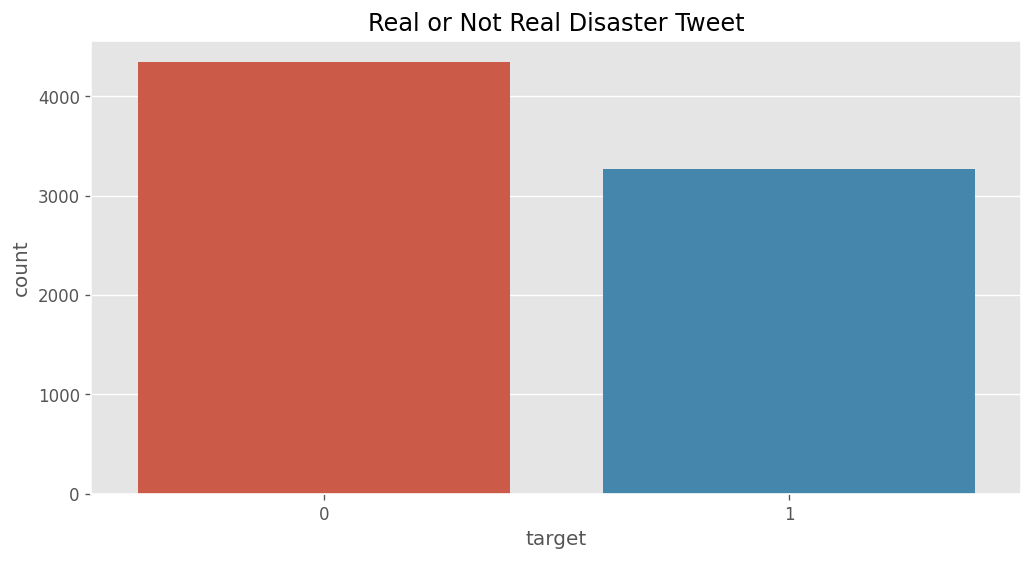

In [8]:
sns.countplot('target', data = tweet)
plt.title('Real or Not Real Disaster Tweet')


In [9]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

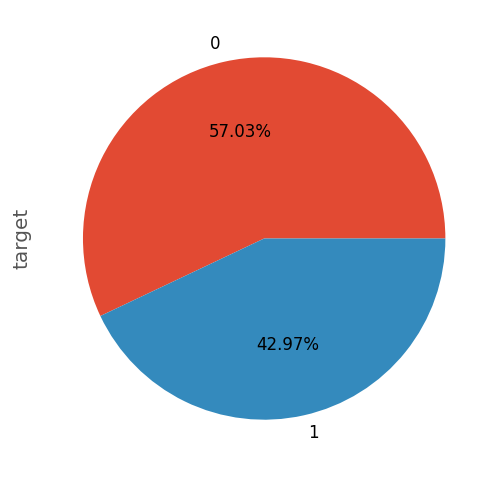

In [10]:
tweet['target'].value_counts().plot.pie(autopct = '%1.2f%%')

 **Number of Characters Distribution in Tweets**

In [11]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-s9j5aocy
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-s9j5aocy
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11754 sha256=c7b1d78ca170c29302e0be324a8a998b641bf8abaca2951a03c1fe6b4f658520
  Stored in directory: /tmp/pip-ephem-wheel-cache-qj3mjiep/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie


In [12]:
#We can do lots of preprocessing like can calculate total no of characters, total no of words , avg no of character per word, 
#we can also find any links, email, phone no with this package
import preprocess_kgptalkie as kgp

In [13]:
kgp.get_basic_features(tweet)
#Some of the new feature are added by this package like char_counts,	word_counts,	avg_wordlength,	stopwords_counts,	hashtag_counts e.t,c

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,73,11,6.636364,2,0,0,2,0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,106,20,5.300000,9,0,2,2,0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,58,8,7.250000,1,0,0,7,2
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,119,19,6.263158,6,0,0,2,0


In [14]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


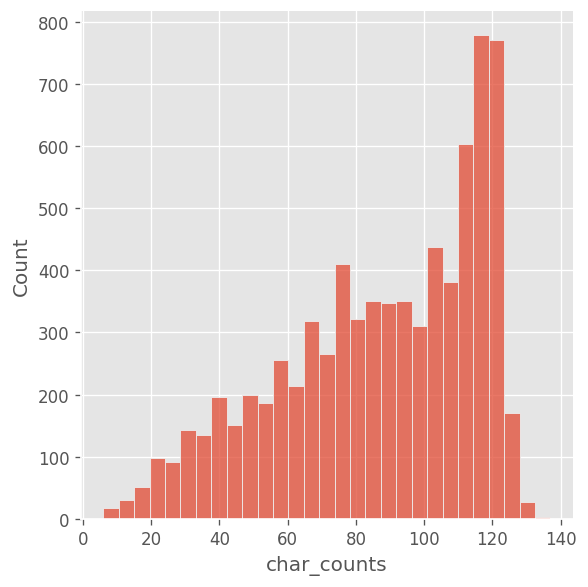

In [15]:
sns.displot(tweet['char_counts'])

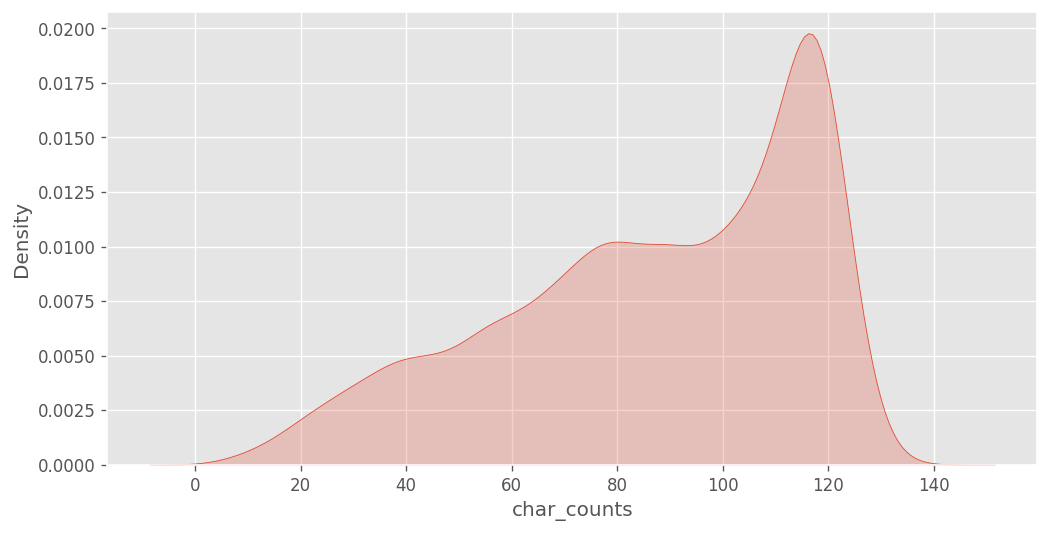

In [16]:
sns.kdeplot(tweet['char_counts'], shade=True)

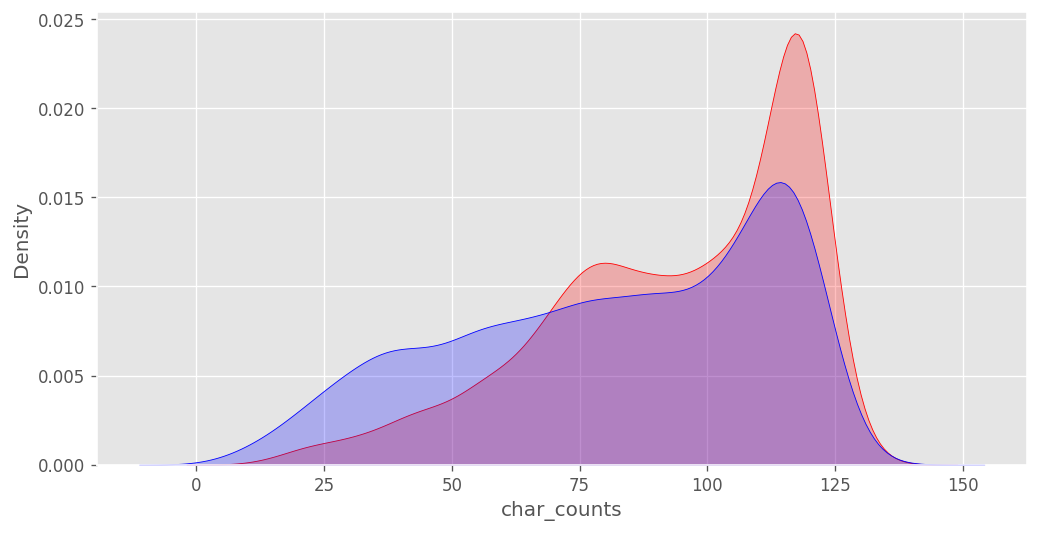

In [17]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color = 'red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color = 'blue')

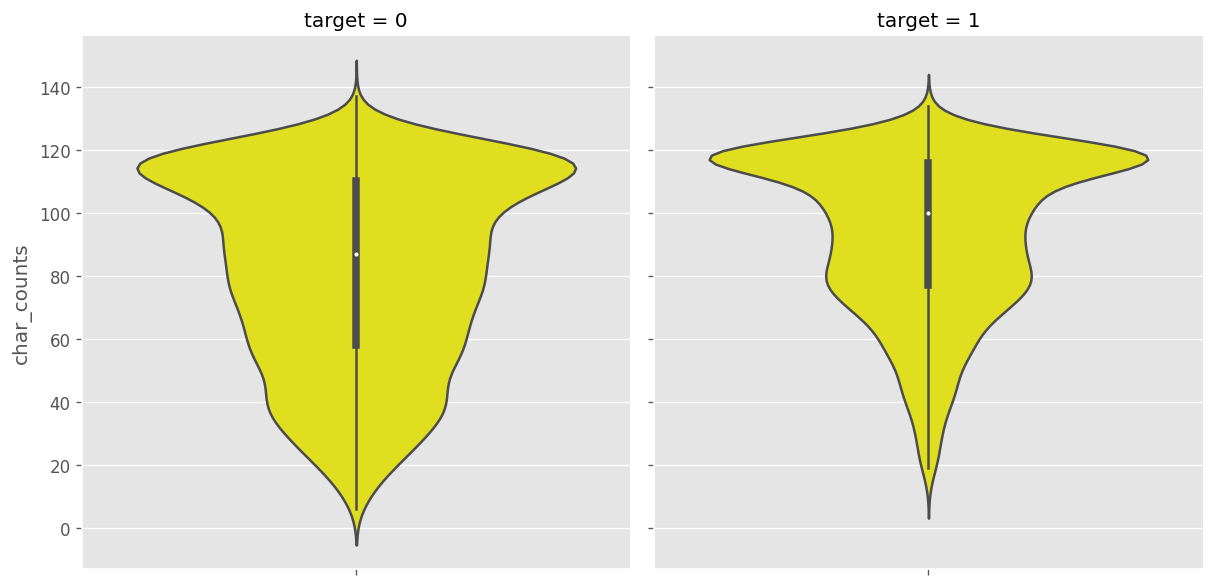

In [18]:
sns.catplot(y = 'char_counts', data = tweet, kind = 'violin', col = 'target',  color = 'Yellow')

Number of Words, Average words length, and Stop words Distribution in Tweets

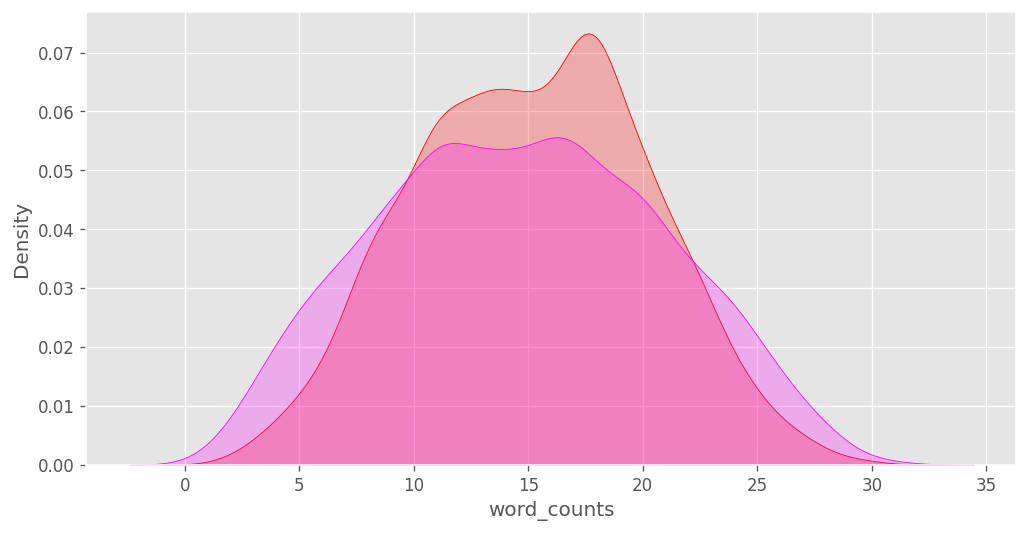

In [19]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color = 'red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color = 'magenta')

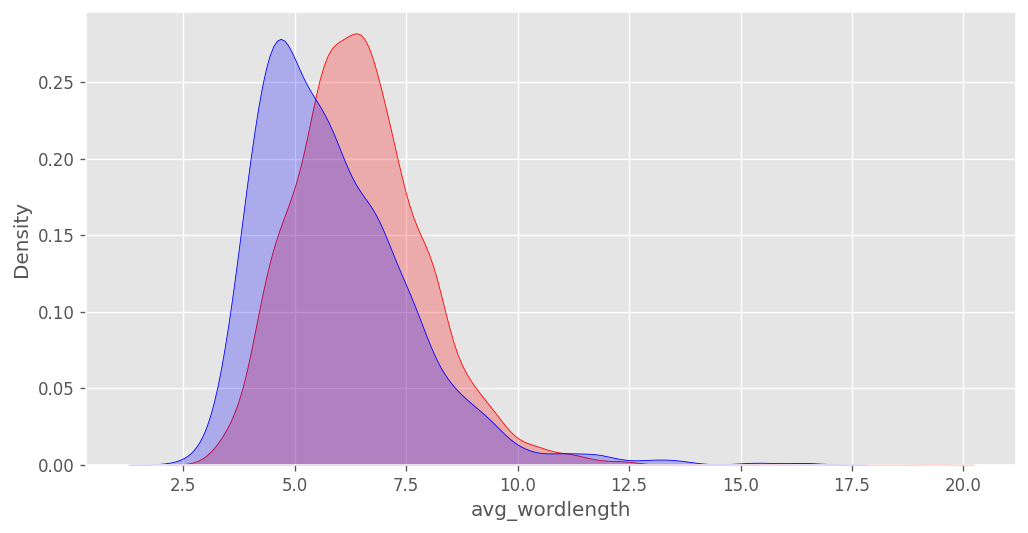

In [20]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color = 'red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color = 'blue')

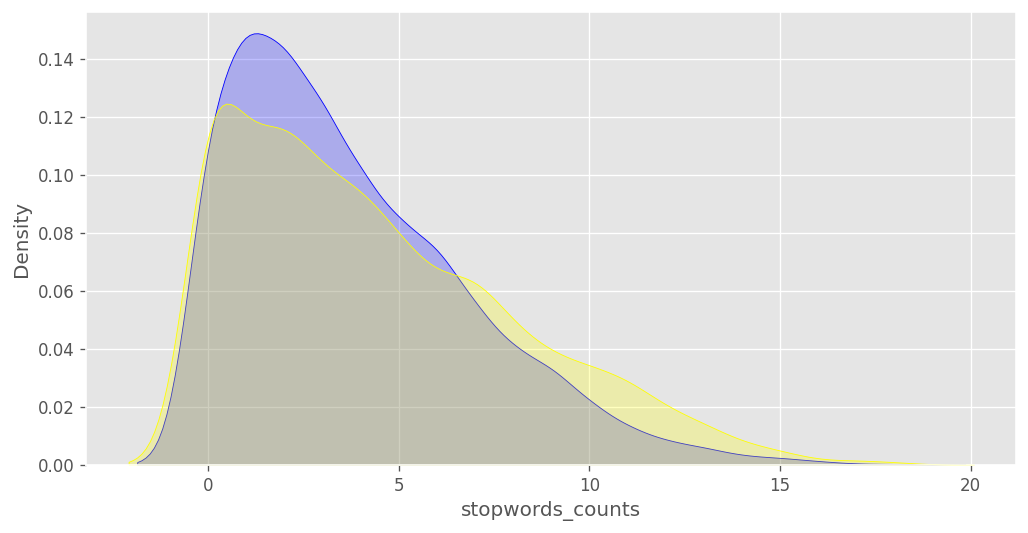

In [21]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color = 'Blue')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color = 'Yellow')

In [22]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

Most and Least common words

In [23]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [24]:
top20 = freqs[100:120]

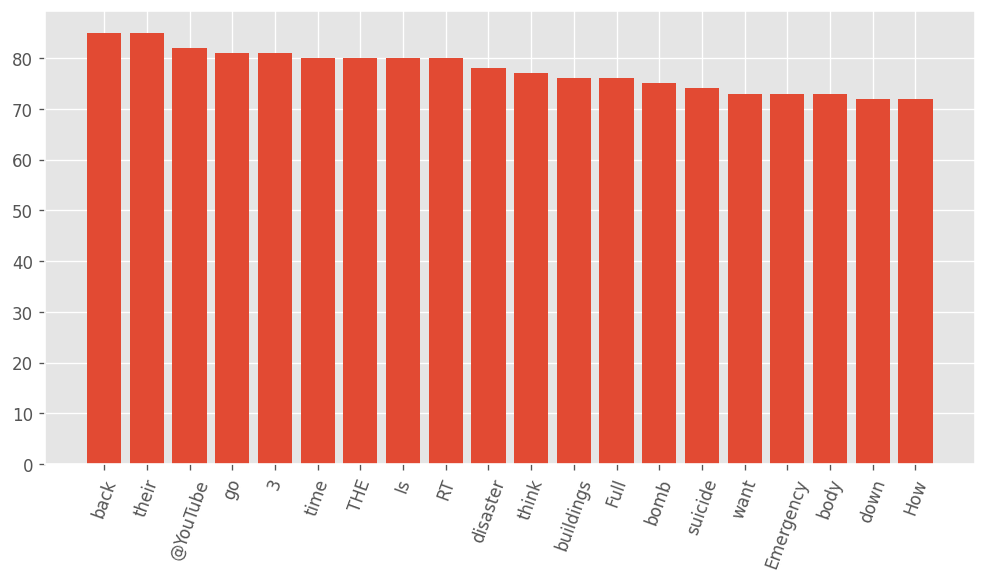

In [25]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation = 70)
plt.show()

In [26]:
least20 = freqs[-20:]
least20

sunkÛ_1                   1
@5SOSFamUpdater            1
@Ophiuchus2613:            1
8:15                       1
'H-Hello..'                1
#WakeUpFlorida...          1
seemeth                    1
tolerance                  1
http://t.co/59p3AoIQUS     1
https://t.co/DlVYFvnQee    1
old-timey                  1
#Shantae                   1
reactors!                  1
'Jet                       1
striked                    1
Mad.                       1
#WildHorses                1
billionaire:               1
Diego                      1
2.5                        1
dtype: int64

In [27]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range = 2)

In [28]:
bigram[-20:] #with frequency

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

One Shot Data-Cleaning

In [29]:
import preprocess_kgptalkie as ps

In [30]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ').replace('.', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = ps.remove_dups_char(x)
    return x

In [31]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [32]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [33]:
kgp.get_ngram(tweet, 'text', ngram_range = 2)

[('zxathetis are', 67862),
 ('zurich for', 67861),
 ('zumiez is', 67860),
 ('zss vs', 67859),
 ('zourryart forgot', 67858),
 ('zouma just', 67857),
 ('zouma has', 67856),
 ('zotar50 skeleton', 67855),
 ('zoom in', 67854),
 ('zonewolf123 liked', 67853),
 ('zonesthank god', 67852),
 ('zones donuat', 67851),
 ('zone with', 67850),
 ('zone what', 67849),
 ('zone war', 67848),
 ('zone they', 67847),
 ('zone protectdenaliwolves', 67846),
 ('zone outside', 67845),
 ('zone of', 67844),
 ('zone my', 67843),
 ('zone littlewomenla', 67842),
 ('zone laugh', 67841),
 ('zone johnny', 67840),
 ('zone in', 67839),
 ('zone httpt', 67838),
 ('zone during', 67837),
 ('zone common', 67836),
 ('zone coming', 67835),
 ('zone but', 67834),
 ('zone and', 67833),
 ('zone amirite', 67832),
 ('zombies take', 67831),
 ('zombie fun', 67830),
 ('zombie feel', 67829),
 ('zombie apocalypse', 67828),
 ('zomatoaus lovefood', 67827),
 ('zojadelin you', 67826),
 ('zodiac girl', 67825),
 ('ziuw httpt', 67824),
 ('zippolin

Disaster words visualization with word cloud

In [34]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire are was as have my news httpst over up more via an disaster were be people california suicide has no police who when but been like killed do 2 will hiroshima just than so fires out storm crash families we train now about into emergency s your bomb buildings there all mh370 two what they nuclear attack am video wildfire accident get bombing new one how burning northern minister prime dead legionnaires me bomber some if homes war car still atomic obama he fatal years off forest us collapse may city retweet debris watch first today malaysia japan 1 or mass man latest near severe water had earthquake those confirmed before found oil would 70 floods world spill down army warning home under derailment injured 3 weather wreckage 4 evacuation could outbreak saudi 40 migrants thunderstorm being old our missing can during flood say flooding investigators bridge time their death suspect mosque her state back cha

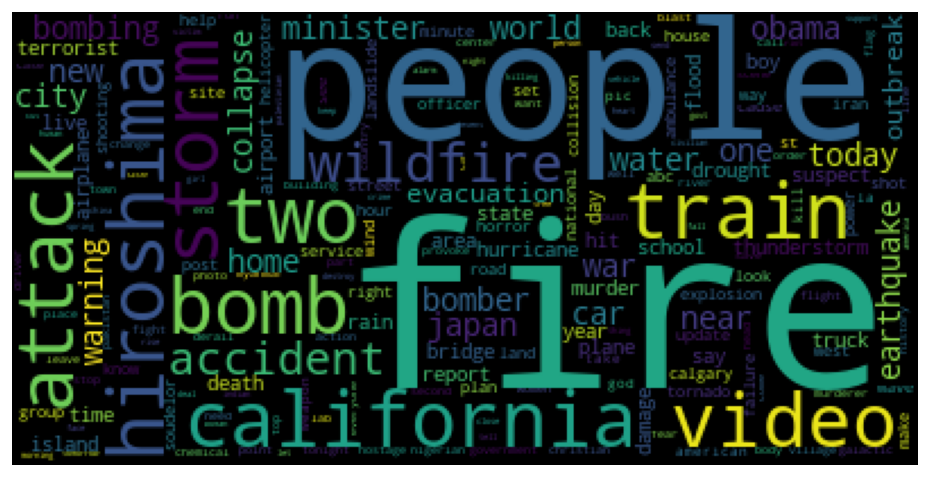

In [35]:
#When disaster happen, then we can see these words more on twitter
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

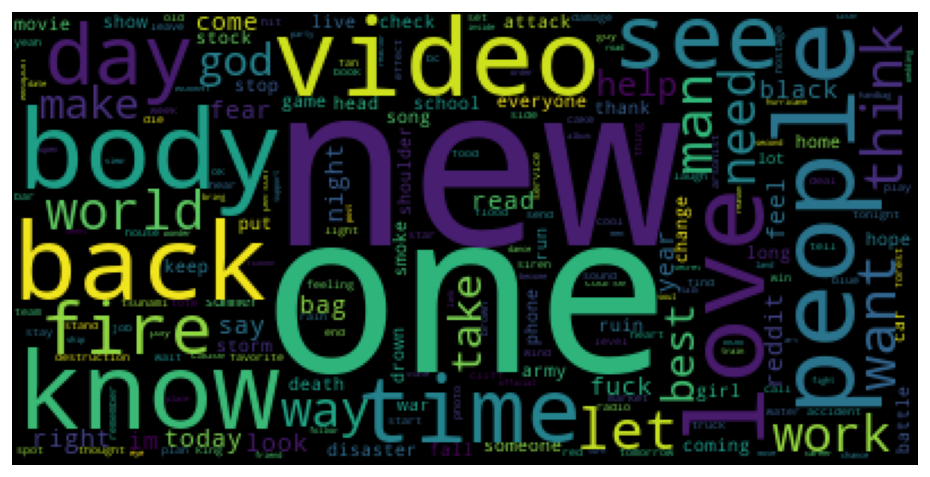

In [36]:
#For NOT REAL plot
#When disaster not happen, then we can see these words more on twitter
nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
nreal
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Classification with TFIDF and SVM

In [37]:
text = tweet['text']
y = tweet['target']


In [38]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [39]:
X.shape

(7613, 22546)

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 0, stratify = y)

In [41]:
#Creating our classifier
def run_SVM(clf,X_train,y_train,X_test,y_test): 
  clf.fit(X_train,y_train) 
  y_pred = clf.predict(X_test) #prediction is done on the testing dataset

  print() #print new line
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [42]:
from sklearn.svm import LinearSVC

In [43]:
#calling classifier
clf = LinearSVC()
run_SVM(clf, X_train, y_train, X_test, y_test) #We got 0.81(recall) accuracy, we can improve by hyperparametrized tunning.


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



Classification with Word2Vec and SVM

In [44]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [45]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=8c435ed3bd7ec0f478ba13f74439d0ebafc99716b621537fcfa6bd6d6ba47a0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-gh2cf038/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [46]:
import spacy
import en_core_web_lg

In [47]:
nlp = en_core_web_lg.load()


In [48]:
x = 'cat dog'
doc = nlp(x)


In [49]:
doc.vector.shape

(300,)

In [50]:
#creating method
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [51]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [51]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-0.13400537, 0.25267026, 0.09032763, -0.16645..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [52]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1,1)

In [53]:
X.shape

(7613, 1)

In [54]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1,300)

In [55]:
X.shape

(7613, 300)

In [56]:
y = tweet['target']

In [57]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 0, stratify = y)

In [58]:
X_train.shape

(6090, 300)

In [59]:
X_test.shape

(1523, 300)

In [60]:
y_train.shape

(6090,)

In [61]:
y_test.shape

(1523,)

In [62]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,y_train,X_test,y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

CPU times: user 4.06 s, sys: 38.4 ms, total: 4.1 s
Wall time: 4.08 s


Word Embeddings and Classification with Deep Learning

In [63]:
token = Tokenizer()
token.fit_on_texts(text)

In [64]:
vocab_size = len(token.word_index)+1
vocab_size

22582

In [65]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [66]:
encoded_text = token.texts_to_sequences(text)


In [67]:
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 371, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [68]:
max_length = 40
X = pad_sequences(encoded_text, maxlen = max_length, padding = 'post')

In [69]:
print(X)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [70]:
X.shape

(7613, 40)

In [71]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, random_state = 0, stratify = y)

In [72]:
%%time
clf = LinearSVC()
run_SVM(clf,X_train,y_train,X_test,y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.61      0.56      0.58       869
           1       0.47      0.52      0.49       654

    accuracy                           0.54      1523
   macro avg       0.54      0.54      0.54      1523
weighted avg       0.55      0.54      0.54      1523

CPU times: user 802 ms, sys: 10.4 ms, total: 812 ms
Wall time: 804 ms


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Word Embeddings and Classification with Deep Learning

In [79]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation = 'relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation = 'sigmoid'))

In [80]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 100)           2258200   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 19, 32)            1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 19, 16)           

In [83]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 32s 12ms/step - loss: 0.6665 - accuracy: 0.5874 - val_loss: 0.6263 - val_accuracy: 0.7163
Epoch 2/5
191/191 [==============================] - 2s 10ms/step - loss: 0.5233 - accuracy: 0.7611 - val_loss: 0.4785 - val_accuracy: 0.7984
Epoch 3/5
191/191 [==============================] - 2s 10ms/step - loss: 0.3440 - accuracy: 0.8609 - val_loss: 0.4697 - val_accuracy: 0.7840
Epoch 4/5
191/191 [==============================] - 2s 10ms/step - loss: 0.2268 - accuracy: 0.9163 - val_loss: 0.5004 - val_accuracy: 0.7859
Epoch 5/5
191/191 [==============================] - 2s 10ms/step - loss: 0.1410 - accuracy: 0.9504 - val_loss: 0.5711 - val_accuracy: 0.7498


In [86]:
#for prediction
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen = max_length, padding='post')
  return x

In [87]:
x = 'I am thrilled to see this'
vec = get_encoded(x)

In [88]:
vec 

array([[  7,  31,   5, 103,  20,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

In [90]:
np.argmax(model.predict(vec), axis = -1) #Not about any disaster

array([0])

BERT Model Building and training

In [1]:
!pip install ktrain

In [2]:
import ktrain

In [3]:
from ktrain import text

In [7]:
tweet.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
#it will download the bert
(X_train, y_train), (X_test, y_test), preproc =text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

['not_target', 'target']
      not_target  target
330          1.0     0.0
365          1.0     0.0
3135         1.0     0.0
979          1.0     0.0
4612         0.0     1.0
['not_target', 'target']
      not_target  target
6151         1.0     0.0
4555         0.0     1.0
5415         1.0     0.0
2626         1.0     0.0
4479         1.0     0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [9]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [10]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data = (X_test, y_test), batch_size=64)

In [11]:
#validation accuracy is more than training accuracy so model is underfitting that means it needs lot more training
learner.fit_onecycle(lr = 2e-5, epochs=1) 



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 3030s 28s/step - loss: 0.5257 - accuracy: 0.7484 - val_loss: 0.4343 - val_accuracy: 0.8136


In [12]:
#Model has started overfitting, but these accuracy is better than previous accuracy
learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 3028s 28s/step - loss: 0.3680 - accuracy: 0.8489 - val_loss: 0.4382 - val_accuracy: 0.8189
Epoch 2/3
108/108 [==============================] - 3043s 28s/step - loss: 0.3341 - accuracy: 0.8656 - val_loss: 0.4232 - val_accuracy: 0.8294
Epoch 3/3
108/108 [==============================] - 3050s 28s/step - loss: 0.2403 - accuracy: 0.9126 - val_loss: 0.4710 - val_accuracy: 0.8202


In [ ]:
#we need to play with learning rate to acheive the good accuracy
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data = (X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 2e-5, epochs=3)

In [ ]:
#Find out the best learning rate
#learner.lr_find()
#learner.lr_plot()

Prediction 

In [13]:
predictor =  ktrain.get_predictor(learner.model, preproc)

In [14]:
data = ['i met you today by accident', 'i got today car accident , i am injured']

In [15]:
predictor.predict(data, return_proba=True)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:215: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  warnings.warn('List or array of two texts supplied, so task being treated as text classification. ' +\


array([[0.90146065, 0.09853938],
       [0.09677175, 0.9032283 ]], dtype=float32)

In [16]:
predictor.predict(data[1]) #target = Disaster has happened

'target'

In [19]:
classes = predictor.get_classes()

In [20]:
data

['i met you today by accident', 'i got today car accident , i am injured']

In [21]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1